In [1]:
from google.cloud import bigquery

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/pavannaik/Desktop/API/sql-kaggle-244915-e2d3c0bfe87b.json"

In [3]:
client = bigquery.Client()

In [4]:
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

In [5]:
dataset = client.get_dataset(dataset_ref)

In [6]:
tables = list(client.list_tables(dataset))
for table in tables:
    print(table.table_id)

taxi_trips


In [7]:
table_ref = dataset_ref.table("taxi_trips")

In [8]:
table = client.get_table(table_ref)

In [9]:
client.list_rows(table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,51e9ac7992f73fe611a658196e8bdedc309c6a9c,148b56c4e0be7f03cac1f44bfd98d7d7cd18b9935d644a...,2013-04-07 17:00:00+00:00,2013-04-07 17:00:00+00:00,None,0.0,None,None,None,None,...,0.0,46.86,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
1,cc1557aa4739cdd8fd2a835b6a5c721bb55387c0,b2b9295effcd71dadf837c7801fd3b8a285f5bdefffb18...,2013-04-07 17:00:00+00:00,2013-04-07 16:45:00+00:00,None,0.0,None,None,None,None,...,0.0,44.22,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
2,0777b61b1d52643224b21afb9bac3d6f0dbc26fd,92c7e4860654a8a87e459b0471572be4266569e48af141...,2013-04-07 14:45:00+00:00,2013-04-07 14:30:00+00:00,None,0.0,None,None,None,None,...,0.0,11.34,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
3,a0d5f5a0306f3ee3f68e18a88eefff8add909a3b,1ab1d8e0fd730376b1bfaf30fadc2901ba10f5ea75a225...,2013-04-20 18:45:00+00:00,2013-04-20 18:45:00+00:00,None,0.0,None,None,None,None,...,0.0,10.50,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
4,02fe736a5c738a58a88fc2fa7ec10ad3f7f979c0,bda6f18f96bd0d6b78f228e56d927386d5b2f5646088d3...,2013-03-30 02:15:00+00:00,2013-03-30 02:15:00+00:00,None,0.0,None,None,None,None,...,0.0,20.09,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None


In [10]:
rides_per_year_query = """SELECT COUNT(1) AS num_trips, EXTRACT(YEAR FROM trip_start_timestamp) AS year
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY year
ORDER BY year"""

In [11]:
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_year_query_job = client.query(rides_per_year_query, job_config=safe_config)
rides_per_year_result = rides_per_year_query_job.to_dataframe()
print(rides_per_year_result)

   num_trips  year
0   27217716  2013
1   37395436  2014
2   32385875  2015
3   31759339  2016
4   24988003  2017
5   20732088  2018
6    9843414  2019


In [43]:
rides_per_month_query = """SELECT EXTRACT(MONTH FROM trip_start_timestamp) AS month, COUNT(1) AS num_trips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2017
GROUP BY month
ORDER BY month"""

In [44]:
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_month_query_job = client.query(rides_per_month_query, job_config=safe_config)
rides_per_month_result= rides_per_month_query_job.to_dataframe()
print(rides_per_month_result)


    month  num_trips
0       1    1972071
1       2    1909802
2       3    2362105
3       4    2194702
4       5    2323386
5       6    2324472
6       7    2054299
7       8    2079861
8       9    1950631
9      10    2141197
10     11    1907997
11     12    1767480


In [54]:
speeds_query = """
               WITH RelevantRides AS
               (
                   SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, trip_miles, trip_seconds
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE trip_start_timestamp > '2017-01-01' AND trip_start_timestamp < '2017-07-01' AND trip_miles > 0 AND trip_seconds > 0
               )
               SELECT hour_of_day, COUNT(1) AS num_trips, 3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
               FROM RelevantRides
               GROUP BY hour_of_day
               ORDER BY hour_of_day
               """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
speeds_query_job = client.query(speeds_query, job_config=safe_config)


speeds_result = speeds_query_job.to_dataframe()

print(speeds_result)

    hour_of_day  num_trips    avg_mph
0             0     319339  20.230524
1             1     266529  18.937621
2             2     210147  18.777070
3             3     159668  20.158048
4             4     122183  26.736014
5             5     119312  30.769172
6             6     182738  24.588313
7             7     358406  17.735967
8             8     541775  15.079892
9             9     565548  16.543882
10           10     525120  18.539614
11           11     594603  18.928379
12           12     622324  17.838745
13           13     630181  17.671089
14           14     622465  16.974239
15           15     640430  15.688418
16           16     701435  14.283888
17           17     756627  12.462955
18           18     768251  13.646810
19           19     701064  16.642882
20           20     598614  19.536777
21           21     552726  20.433874
22           22     501095  19.531374
23           23     399587  19.877046


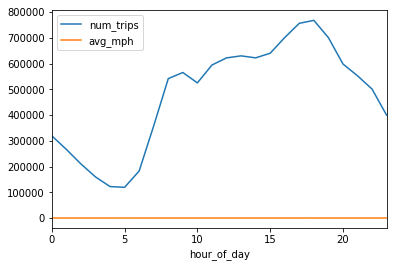

In [60]:
speeds_result.set_index('hour_of_day').plot()